In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [ ]:
import pandas as pd


read training data file

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/heartbeat_dataset/mitbih_train.csv',header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


classes counts


In [ ]:
df_train[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

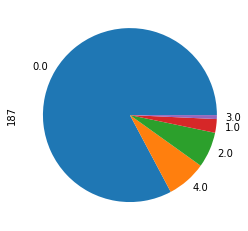

In [ ]:
df_train[187].value_counts().plot.pie()

training data resample

In [ ]:
from sklearn.utils import resample
df_1=df_train[df_train[187]==1]
df_2=df_train[df_train[187]==2]
df_3=df_train[df_train[187]==3]
df_4=df_train[df_train[187]==4]
df_0=df_train[df_train[187]==0].sample(n=18000,random_state=42, replace=True)

df_1_upsample=resample(df_1,replace=True,n_samples=18000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=18000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=18000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=18000,random_state=126)

train_df_resample=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])


In [ ]:
train_df_resample[187].value_counts()

1.0    18000
3.0    18000
4.0    18000
2.0    18000
0.0    18000
Name: 187, dtype: int64

take a sample from each class for plotting

In [ ]:
four_rows = train_df_resample.groupby(187).first().reset_index()
four_rows.drop(187, axis=1, inplace=True)
#four_rows

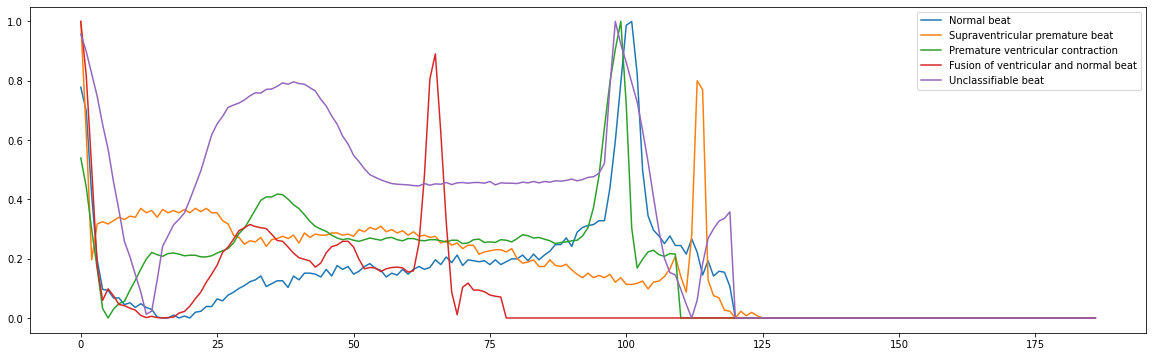

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 187)

plt.figure(figsize=(20,6))
plt.plot(x, four_rows.iloc[0], label="Normal beat")
plt.plot(x, four_rows.iloc[1], label="Supraventricular premature beat")
plt.plot(x, four_rows.iloc[2], label="Premature ventricular contraction")
plt.plot(x, four_rows.iloc[3], label="Fusion of ventricular and normal beat")
plt.plot(x, four_rows.iloc[4], label="Unclassifiable beat")
plt.legend()
plt.show()

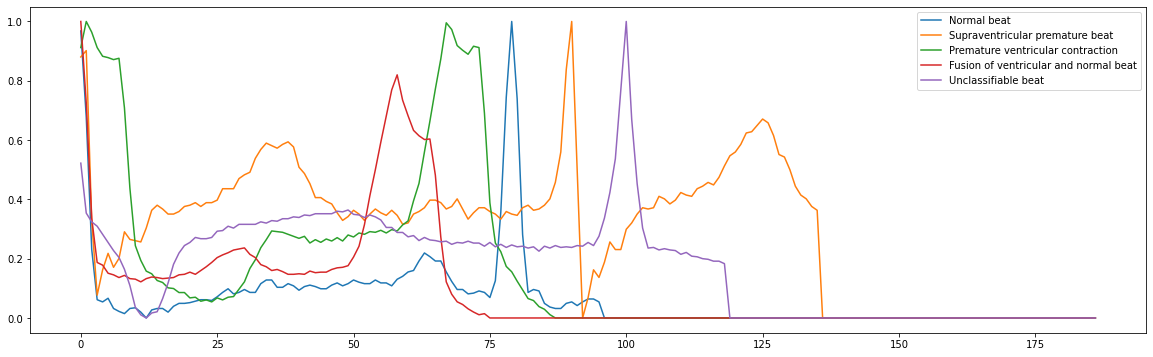

In [ ]:
four_rows_2 = train_df_resample.groupby(187).tail(1).reset_index()
four_rows_2.drop('index', axis=1, inplace=True)
four_rows_2.drop(187, axis=1, inplace=True)

plt.figure(figsize=(20,6))
plt.plot(four_rows_2.iloc[0], label="Normal beat")
plt.plot(four_rows_2.iloc[1], label="Supraventricular premature beat")
plt.plot(four_rows_2.iloc[2], label="Premature ventricular contraction")
plt.plot(four_rows_2.iloc[3], label="Fusion of ventricular and normal beat")
plt.plot(four_rows_2.iloc[4], label="Unclassifiable beat")
plt.legend()
plt.show()


read testing data file

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/heartbeat_dataset/mitbih_test.csv', header=None)

split class from features for traing data

In [ ]:
y=train_df_resample[187]
X=train_df_resample.drop(187, axis=1).values


reshape X (features vector) to fit into the model

In [ ]:
X = X.reshape((len(X),187,1))
X.shape

(90000, 187, 1)

Convert classes to binary class matrix

In [ ]:
from keras.utils import to_categorical

y= y.values.reshape((len(y.values),1))
y = to_categorical(y)
y.shape

(90000, 5)

split and reshape testing data

In [ ]:
y_test=df_test[187]
X_test=df_test.drop(187, axis=1).values
X_test = X_test.reshape((len(X_test),187,1))
y_test= y_test.values.reshape((len(y_test.values),1))
y_test = to_categorical(y_test)

model

In [ ]:
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.layers import LSTM, Dense, Flatten, Activation, MaxPool1D, Conv1D
from keras.layers.normalization import BatchNormalization

def network(X_train1,y_train1,test_x,test_y):
    

    im_shape=(187,1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    flatten=Flatten()(pool2)
    #dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(flatten)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    sgd = SGD(lr=0.0001, decay=1e-6)

    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='egc_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train1, y_train1,epochs=10 , batch_size=32,callbacks=callbacks,validation_data=(test_x,test_y))
    return(model,history)


In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X,y, X_test,y_test)

Train on 90000 samples, validate on 21892 samples
Epoch 1/10
90000/90000 [==============================] - 74s 825us/step - loss: 0.2239 - accuracy: 0.9202 - val_loss: 0.3491 - val_accuracy: 0.8754
Epoch 2/10
90000/90000 [==============================] - 74s 820us/step - loss: 0.0853 - accuracy: 0.9714 - val_loss: 0.2343 - val_accuracy: 0.9349
Epoch 3/10
90000/90000 [==============================] - 74s 818us/step - loss: 0.0548 - accuracy: 0.9817 - val_loss: 0.1826 - val_accuracy: 0.9516
Epoch 4/10
90000/90000 [==============================] - 74s 825us/step - loss: 0.0411 - accuracy: 0.9867 - val_loss: 0.1702 - val_accuracy: 0.9571
Epoch 5/10
90000/90000 [==============================] - 74s 826us/step - loss: 0.0331 - accuracy: 0.9896 - val_loss: 0.1391 - val_accuracy: 0.9667
Epoch 6/10
90000/90000 [==============================] - 73s 809us/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.1809 - val_accuracy: 0.9593
Epoch 7/10
90000/90000 [==============================] 

In [ ]:
model.evaluate(X_test,y_test)

21892/21892 [==============================] - 5s 226us/step


[0.21184678603389945, 0.9687557220458984]

loss performance

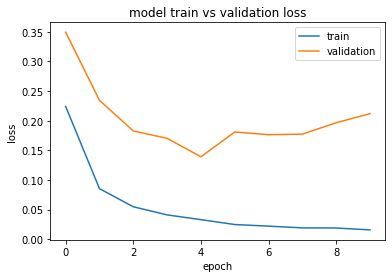

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

accuracy performance

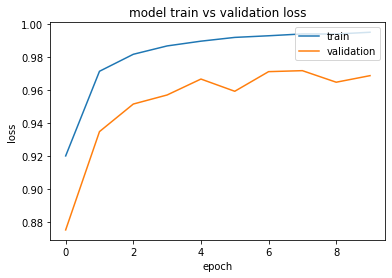

In [ ]:

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

load saved model

In [ ]:
from keras.models import load_model

loaded_model = load_model('/content/drive/My Drive/heartbeat_dataset/egc_model.h5')
loaded_model.evaluate(X_test,y_test)

685/685 [==============================] - 4s 6ms/step - loss: 0.1391 - accuracy: 0.9667


[0.13907895982265472, 0.9667001366615295]

classification report

In [ ]:
from sklearn.metrics import classification_report

predz = loaded_model.predict(X_test).argmax(axis=-1)
print(classification_report(df_test[187].values,predz) )


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18118
         1.0       0.58      0.86      0.69       556
         2.0       0.92      0.95      0.93      1448
         3.0       0.57      0.88      0.69       162
         4.0       0.97      0.99      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.81      0.93      0.86     21892
weighted avg       0.97      0.97      0.97     21892



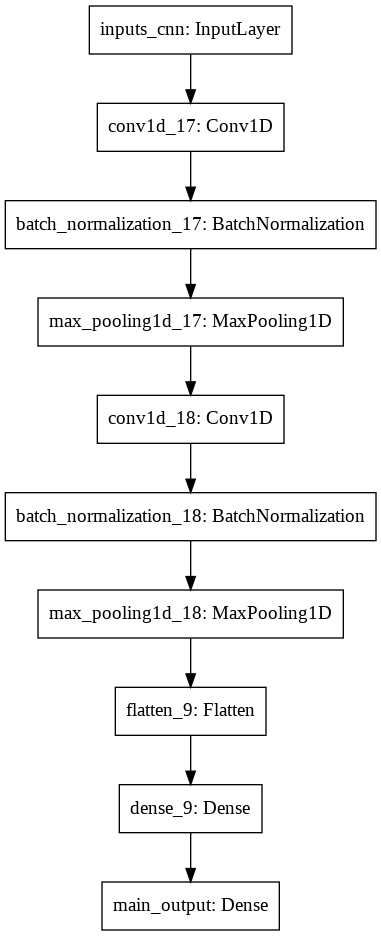

In [ ]:
from keras.utils import plot_model
plot_model(loaded_model, to_file='model.png')

In [ ]:
loaded_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 187, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 182, 64)           448       
_________________________________________________________________
batch_normalization_17 (Batc (None, 182, 64)           256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 91, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 89, 64)            12352     
_________________________________________________________________
batch_normalization_18 (Batc (None, 89, 64)            256       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 45, 64)            0   

In [ ]:
inv_vals = {0:'N', 1:'S', 2:'V', 3:'F',  4:'Q'}

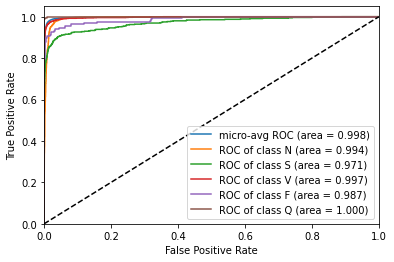

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes=5
proba_pred = loaded_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
yt = y_test


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt[:, i], proba_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt.ravel(), proba_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg ROC (area = {0:0.3f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC of class {0} (area = {1:0.3f})'
                                   ''.format(inv_vals[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('CNN_roc.pdf', format='pdf')


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_test[187].values,predz)


array([[17584,   327,    97,    69,    41],
       [   64,   476,     9,     5,     2],
       [   29,    10,  1370,    31,     8],
       [   10,     2,     8,   142,     0],
       [   11,     3,     3,     0,  1591]])